# Notebook to visualize simulated Alpine-3D grids
## First, import packages

In [18]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd

## Add netCDF file path, define grid variable to plot, and time step.

In [19]:
nc_path = "../output/grids/a3d_grids.nc"
ds = xr.open_dataset(nc_path)
tgt_time = "1980-01-02T12:00:00" # Specific timestep
tgt_time_ind = -1 # Last timestep
var_plot = "swe"
ds

<xarray.Dataset>
Dimensions:                (easting: 168, northing: 107, time: 28)
Coordinates:
  * time                   (time) datetime64[ns] 1980-01-01T12:00:00 ... 1980-01-15
  * northing               (northing) float32 -109000.0 -108000.0 ... -3000.0
  * easting                (easting) float32 -1542000.0 ... -1375000.0
Data variables:
    dw                     (time, northing, easting) float32 ...
    snd                    (time, northing, easting) float32 ...
    rlds                   (time, northing, easting) float32 ...
    rsds                   (time, northing, easting) float32 ...
    swe                    (time, northing, easting) float32 ...
    ta                     (time, northing, easting) float32 ...
    ws                     (time, northing, easting) float32 ...
    VW_DRIFT               (time, northing, easting) float32 ...
    WINDEROSIONDEPOSITION  (time, northing, easting) float32 ...
Attributes:
    date_created:              2020-06-17
    creator_name:              erke2265
    source:                    MeteoIO-2.81
    history:                   2020-06-17T21:23:13Z, erke2265@shas0253.rc.int...
    keywords_vocabulary:       AGU Index Terms
    keywords:                  Cryosphere, Mass Balance, Energy Balance, Atmo...
    title:                     Gridded data for various parameters and timesteps
    institution:               colorado.edu
    product_version:           1.0
    Conventions:               CF-1.6,ACDD-1.3
    standard_name_vocabulary:  CF-1.6
    cdm_data_type:             Grid
    geospatial_bounds_crs:     EPSG:3031
    geospatial_bounds:         Polygon ((-1542000.0000000000 -109000.00000000...

## Load coastlines data

In [20]:
df = gpd.read_file("/pl/active/nasa_smb/Data/ADD_Coastline_low_res_polygon.shp")
crs_epsg = ccrs.SouthPolarStereo()
df_epsg = df.to_crs(epsg='3031')

/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


## Plot grid

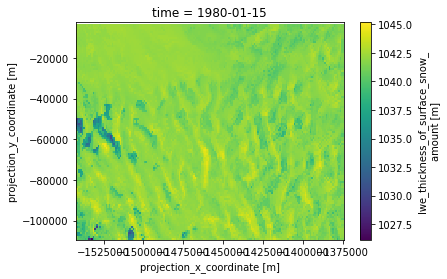

In [21]:
# Plot on specific day
# ds.sel(time=tgt_time)[var_plot].plot()

# Plot last timestep
ds.isel(time=tgt_time_ind)[var_plot].plot()

## Plot map

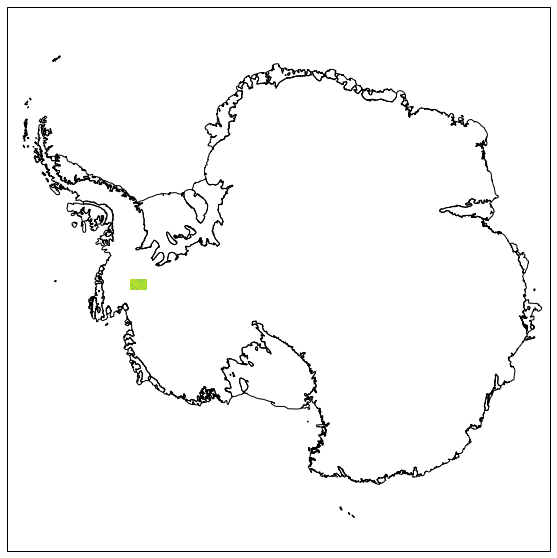

In [22]:
# Generate figure 
fig, axs = plt.subplots(1, 1, subplot_kw={'projection': crs_epsg},
                        figsize=(10, 10))

# Plot coastlines
axs.set_extent((-180, 180, -90, -65), ccrs.PlateCarree()) # Full ice sheet
# axs.set_extent((-110, -70, -85, -70), ccrs.PlateCarree()) # Zoom in on Alpine-3D domain
axs.add_geometries(df_epsg['geometry'], crs=crs_epsg,
                      facecolor='none', edgecolor='black')

# Define easting and northings
northings = ds.sel(time=tgt_time)[var_plot]['northing']
eastings = ds.sel(time=tgt_time)[var_plot]['easting']

# Plot map
mesh = plt.pcolormesh(eastings, northings, ds.sel(time=tgt_time)[var_plot])

## Plot last timestep minus first timestep

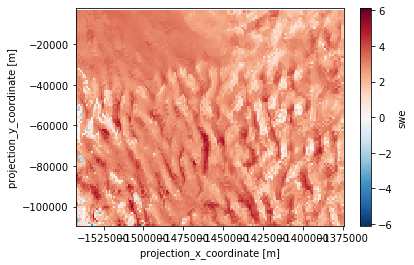

In [23]:
diff = ds[var_plot].isel(time=-1) - ds[var_plot].isel(time=0)
diff.plot()